In [1]:
!pip install concise

     |████████████████████████████████| 1.3MB 4.6MB/s 
     |████████████████████████████████| 317kB 26.8MB/s 
  Created wheel for gtfparse: filename=gtfparse-1.2.0-cp36-none-any.whl size=11883 sha256=d859693f81931f68ed2f74fa9d101482fb272d36e014c5c7bfe9246cf096d624
  Stored in directory: /root/.cache/pip/wheels/c4/27/96/6ba6fe28cbb162c326823553e3e45ac502160d1340566360f8
Successfully built gtfparse
  Found existing installation: Keras 2.3.1
    Uninstalling Keras-2.3.1:
      Successfully uninstalled Keras-2.3.1


In [2]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive 


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive
/gdrive


In [3]:
cd /gdrive/My\ Drive/nn 


/gdrive/My Drive/nn


In [4]:
%tensorflow_version 1.x
import argparse
import os
import pickle
import sys

import numpy as np

np.random.seed(7)  # for reproducibility

import tensorflow as tf
tf.random.set_random_seed(5005)

from sklearn.model_selection import train_test_split, KFold

# tf.python.control_flow_ops = tf


from tensorflow.python.keras.models import Model, load_model
from tensorflow.python.keras.layers import Input
from tensorflow.python.keras.layers import Dense, Flatten, Dropout
from tensorflow.python.keras.layers.convolutional import Conv1D
from tensorflow.python.keras.layers.pooling import MaxPooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.python.keras.callbacks import ModelCheckpoint, EarlyStopping
import tensorflow.python.keras.backend as K

import matplotlib as mpl

mpl.use('Agg')
# from keras.utils.layer_utils import print_layer_shapes

import utils
sys.path.append(".")
from utils import load_data_merged
import plotseqlogo
import IntegratedGradients
from plotseqlogo import *
from IntegratedGradients import *
from utils import *

from tensorflow.python.keras.backend import set_session

model_path = "./models/final.h5"

CLASS_PARTIAL_LOSS = 0
CLASS_COMPLETELY_LOSS = 1 

TensorFlow 1.x selected.


Using TensorFlow backend.
2020-05-11 15:14:48,513 [INFO] Generating grammar tables from /usr/lib/python3.6/lib2to3/Grammar.txt
2020-05-11 15:14:48,536 [INFO] Generating grammar tables from /usr/lib/python3.6/lib2to3/PatternGrammar.txt


2020-05-11 15:14:49,025 [WARNING] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

/gdrive/My Drive/nn/plotseqlogo.py:34: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  min_coords = np.vstack(data.min(0) for data in polygons_data).min(0)
/gdrive/My Drive/nn/plotseqlogo.py:35: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  max_coords = np.vstack(data.max(0) for data in polygons_data).max(0)


In [0]:
x_train_seq, y_train, x_valid_seq, y_valid, x_test_seq, y_test = load_data_merged(r"dataset/solo_test_with_crc10_var_0.05.pkl", 150, False)

In [0]:
def get_refrence_list_zeros(seq_example):
    rf = np.zeros(seq_example.shape)
    m = int(seq_example.shape[0]/ 2 - 1)
    rf[m][1]=1
    rf[m+1][2] = 1
    return rf

In [0]:
def get_refrence_list_equal(seq_example):
    rf = np.zeros(seq_example.shape)
    rf.fill(0.25)
    m = int(seq_example.shape[0]/ 2 - 1)
    rf[m] = 0
    rf[m+1] = 0
    rf[m][1]=1
    rf[m+1][2] = 1
    return rf

In [0]:
def get_ex_seq(predict_label, number_of_seq, thr=0.5):

  sess = tf.Session()
  tf.random.set_random_seed(5005)
  K.set_session(sess)

  session = K.get_session()
  init = tf.global_variables_initializer()
  session.run(init)

  with session.as_default():
      with session:
        model = load_model(model_path, custom_objects={'recall_TP': recall_TP,'recall_TN': recall_TN })
        pred = model.predict(x_test_seq)
        ind= []

        if predict_label ==CLASS_PARTIAL_LOSS:
          pred = 1 - pred

        for i in sorted(enumerate(pred), key=lambda x:x[1],reverse=True):
          if y_test[i[0]]==predict_label and pred[i[0]] > thr:
            ind.append(i[0])
        
        if number_of_seq != -1:
          ind = ind[:number_of_seq]
        
        rf = get_refrence_list_equal(x_test_seq[0])

        gradients = integrated_gradients(model) 
        ex_seq=np.array([gradients.explain([x_test_seq[i]],reference=[rf],num_steps=100)[0] for i in ind])

        if predict_label == CLASS_PARTIAL_LOSS:
          ex_seq = ex_seq * -1
  
  return ex_seq

In [0]:
def get_ex_seq_failed(predict_label, number_of_seq, thr=0.5):

  sess = tf.Session()
  tf.random.set_random_seed(5005)
  K.set_session(sess)

  session = K.get_session()
  init = tf.global_variables_initializer()
  session.run(init)

  with session.as_default():
      with session:
        model = load_model(model_path, custom_objects={'recall_TP': recall_TP,'recall_TN': recall_TN })
        pred = model.predict(x_test_seq)
        ind= []

        if predict_label ==CLASS_PARTIAL_LOSS:
          pred = 1 - pred

        for i in sorted(enumerate(pred), key=lambda x:x[1],reverse=True):
          if y_test[i[0]]!=predict_label and pred[i[0]] > thr:
            ind.append(i[0])
        
        if number_of_seq != -1:
          ind = ind[:number_of_seq]
        
        rf = get_refrence_list_equal(x_test_seq[0])

        gradients = integrated_gradients(model) 
        ex_seq=np.array([gradients.explain([x_test_seq[i]],reference=[rf],num_steps=100)[0] for i in ind])

        if predict_label == CLASS_PARTIAL_LOSS:
          ex_seq = ex_seq * -1
  
  return ex_seq

In [0]:
ex_seq,seq = get_ex_seq(predict_label=CLASS_PARTIAL_LOSS, number_of_seq=1)


Evaluated output channel (0-based index): All
Building gradient functions
Progress: 100.0%
Done.


/gdrive/My Drive/nn/plotseqlogo.py:150: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax.set_xticks([], [])


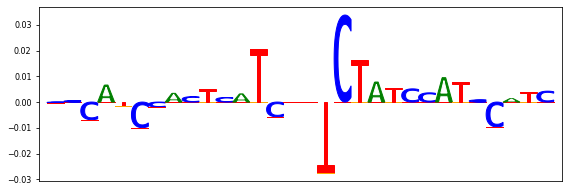

In [0]:
seqlogo_fig(np.transpose(ex_seq[:, 60:90, :4], axes=(1, 2, 0)), vocab="DNA", figsize=(8, ex_seq.shape[0] / 1 + 2), ncol=1)


In [0]:
seq[:,60:90]

In [0]:
ncol = 3
seqlogo_fig(np.transpose(ex_seq[:,60:90,:4],axes=(1,2,0)), vocab="DNA", figsize=(8,20), ncol=2)

In [0]:
label = "partial lost (SCGS)" if predict_label == CLASS_PARTIAL_LOSS else "comletely loss (WCGW)"
print("Graphs for %s -- mean seq" % label)
seqlogo_fig(np.transpose(np.mean(ex_seq[:,60:90,:4],axis=0).reshape(1,30,4),axes=(1,2,0)), vocab="DNA", figsize=(8,4), ncol=1)

In [21]:
import pickle

cl_ex_seq = get_ex_seq(predict_label=CLASS_COMPLETELY_LOSS, number_of_seq=-1, thr=0.75)
pl_ex_seq = get_ex_seq(predict_label=CLASS_PARTIAL_LOSS, number_of_seq=-1, thr=0.75)
cl_ex_seq_failed = get_ex_seq_failed(predict_label=CLASS_COMPLETELY_LOSS, number_of_seq=-1, thr=0.75)
pl_ex_seq_failed = get_ex_seq_failed(predict_label=CLASS_PARTIAL_LOSS, number_of_seq=-1, thr=0.75)

d = {"cl": cl_ex_seq, "pl": pl_ex_seq, "cl_failed": cl_ex_seq_failed, "pl_failed":pl_ex_seq_failed}

with open("./gradients_explain/gradients_explain_baseline_is_equal_dist.pkl", "wb") as f:
  pickle.dump(d, f)

Evaluated output channel (0-based index): All
Building gradient functions
Progress: 100.0%
Done.
Evaluated output channel (0-based index): All
Building gradient functions
Progress: 100.0%
Done.
Evaluated output channel (0-based index): All
Building gradient functions
Progress: 100.0%
Done.
Evaluated output channel (0-based index): All
Building gradient functions
Progress: 100.0%
Done.


In [0]:
y_test.mean()

0.37919052703096184

In [0]:
y_valid[0].mean()

0.31633652138799306

In [0]:
y_train[0].mean()

0.3148116136437496